In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=94958dd7727e1b2d620f4c901f6e0017492d3fd6819a4be1bedf12744564d873
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


<iframe src="https://www.kaggle.com/embed/yasirabd/rul-nasa-bearing-mean-rms-skewness-kurtosis?cellIds=4&kernelSessionId=66346284" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="RUL NASA Bearing (Mean, RMS, Skewness, Kurtosis)"></iframe>




<iframe src="https://www.kaggle.com/embed/yasirabd/rul-nasa-bearing-mean-rms-skewness-kurtosis?cellIds=4&kernelSessionId=66346284" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="RUL NASA Bearing (Mean, RMS, Skewness, Kurtosis)"></iframe>

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

#warningleri kapatmak için
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pyspark import SparkConf , SparkContext
import collections
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lit, col, unix_timestamp , expr
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
conf = SparkConf().setMaster('local').setAppName('RatingsHistogram')
sc = SparkContext(conf=conf)

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("ChurnClassification").getOrCreate()

In [ ]:
dataset_path_1st = '/content/drive/MyDrive/Colab Notebooks/NASA/1st_test/1st_test'
dataset_path_2nd = '/content/drive/MyDrive/Colab Notebooks/NASA/2nd_test/2nd_test'
dataset_path_3rd = '/content/drive/MyDrive/Colab Notebooks/NASA/3rd_test/4th_test/txt'

In [ ]:
merged_data = None

# dataset okumak için dizindeki tüm dosyaları geiyoruz
for filename in os.listdir(dataset_path_2nd):
    # Dosya i,sminden zaman serisi bulma
    timestamp_str = re.sub(r'\D', '', filename)  # Remove non-digits
    timestamp_str = timestamp_str[:14]  # Take the first 14 digits

    # zaman damgasını dönüştürme
    timestamp = unix_timestamp(expr("CAST(substr('{}', 1, 14) AS STRING)".format(timestamp_str)), 'yyyyMMddHHmmss').cast('timestamp')

    # Spark ile dosyayı okuma
    dataset = spark.read.csv(os.path.join(dataset_path_2nd, filename), header=True, inferSchema=True, sep='\t')

    # Okunancoluma yeni sutun ekleme
    dataset = dataset.withColumn('timestamp', lit(timestamp))

    header = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4','timestamp']  # Column isimleri değiştirme
    dataset = dataset.toDF(*header)

    # Dosyalrı birleştirme
    if merged_data is None:
        merged_data = dataset
    else:
        merged_data = merged_data.union(dataset)

# Zaman göre sıralama
windowSpec = Window().orderBy("timestamp")






In [ ]:
merged_data.show(200)

In [ ]:
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

def calculate_entropy(df):
    entropy = []
    for col in df:
        entropy.append(scipy.stats.entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(entropy)

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p']
    cols1 = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    cols2 = ['B1','B2','B3','B4']

    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)

    for filename in os.listdir(dataset_path):
        # read dataset
        dataset = spark.read.csv(os.path.join(dataset_path, filename), header=True, inferSchema=True, sep='\t')
        raw_data = dataset.toPandas()

        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)

        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])

        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]

        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p], axis=1)
        data = data.append(merge)

    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]

    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [ ]:
#Verieleri Okuma
set1 = time_features(dataset_path_1st, id_set=1)
set2 = time_features(dataset_path_2nd, id_set=2)
set3 = time_features(dataset_path_3rd, id_set=3)

In [ ]:
#Verileri CSV Olarak Kaydetme
set1.to_csv(dataset_path_1st+'/set1_timefeatures.csv')
set2.to_csv(dataset_path_2nd+'/set2_timefeatures.csv')
set3.to_csv(dataset_path_3rd+'/set3_timefeatures.csv')


NameError: ignored

In [ ]:
set1 = pd.read_csv(dataset_path_1st+'/set1_timefeatures.csv')
set1 = set1.rename(columns={'Unnamed: 0':'time'})

In [ ]:
set2 = pd.read_csv(dataset_path_2nd+'/set2_timefeatures.csv')
set2 = set2.rename(columns={'Unnamed: 0':'time'})

In [ ]:
set3 = pd.read_csv(dataset_path_3rd+'/set3_timefeatures.csv')
set3 = set3.rename(columns={'Unnamed: 0':'time'})

In [ ]:
set1.head()

,time,B1_a_mean,B1_a_std,B1_a_skew,B1_a_kurtosis,B1_a_entropy,B1_a_rms,B1_a_max,B1_a_p2p,B1_b_mean,...,B4_a_max,B4_a_p2p,B4_b_mean,B4_b_std,B4_b_skew,B4_b_kurtosis,B4_b_entropy,B4_b_rms,B4_b_max,B4_b_p2p
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,0.100253,...,0.413,0.662,0.099513,0.066382,0.008208,1.808719,4.690580,0.115266,0.471,0.845
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,0.099854,...,0.420,0.796,0.093587,0.064747,-0.053721,1.873845,4.666142,0.109210,0.627,0.900
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,0.101543,...,0.396,0.657,0.098299,0.065256,0.047069,1.430242,4.681037,0.113695,0.601,0.977
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,0.101573,...,0.393,0.591,0.098602,0.066304,0.021169,1.378689,4.696194,0.114415,0.525,0.852
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,0.102181,...,0.376,0.591,0.098471,0.066281,0.008713,1.498303,4.693572,0.114260,0.522,0.871


In [ ]:
set2.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B2_mean,...,B3_max,B3_p2p,B4_mean,B4_std,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p
0,2004-02-12 10:32:39,0.058333,0.073478,0.083929,0.629118,4.811406,0.074180,0.454,0.840,0.071832,...,1.023,1.934,0.043067,0.053169,-0.022081,0.066118,4.494251,0.054105,0.264,0.457
1,2004-02-12 10:42:39,0.058995,0.075339,0.052054,0.648930,4.835310,0.075382,0.388,0.757,0.074006,...,0.752,1.433,0.044541,0.055976,0.001645,0.107769,4.545837,0.056102,0.249,0.478
2,2004-02-12 10:52:39,0.060236,0.076189,0.032869,0.514258,4.848343,0.076228,0.503,0.903,0.074227,...,0.933,1.719,0.044443,0.056039,0.070516,0.257503,4.544783,0.056146,0.354,0.688
3,2004-02-12 11:02:39,0.061455,0.078694,0.041523,1.158352,4.761551,0.078726,0.608,1.184,0.073844,...,1.016,1.951,0.045081,0.056686,-0.036409,0.806635,4.553737,0.056808,0.525,1.038
4,2004-02-12 11:12:39,0.061361,0.078440,0.028134,0.603647,4.875062,0.078475,0.391,0.782,0.075609,...,0.771,1.516,0.045118,0.056778,0.019103,0.139316,4.560105,0.056841,0.244,0.456


In [ ]:
set2.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B2_mean,...,B3_max,B3_p2p,B4_mean,B4_std,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p
0,2004-02-12 10:32:39,0.058333,0.073478,0.083929,0.629118,4.811406,0.074180,0.454,0.840,0.071832,...,1.023,1.934,0.043067,0.053169,-0.022081,0.066118,4.494251,0.054105,0.264,0.457
1,2004-02-12 10:42:39,0.058995,0.075339,0.052054,0.648930,4.835310,0.075382,0.388,0.757,0.074006,...,0.752,1.433,0.044541,0.055976,0.001645,0.107769,4.545837,0.056102,0.249,0.478
2,2004-02-12 10:52:39,0.060236,0.076189,0.032869,0.514258,4.848343,0.076228,0.503,0.903,0.074227,...,0.933,1.719,0.044443,0.056039,0.070516,0.257503,4.544783,0.056146,0.354,0.688
3,2004-02-12 11:02:39,0.061455,0.078694,0.041523,1.158352,4.761551,0.078726,0.608,1.184,0.073844,...,1.016,1.951,0.045081,0.056686,-0.036409,0.806635,4.553737,0.056808,0.525,1.038
4,2004-02-12 11:12:39,0.061361,0.078440,0.028134,0.603647,4.875062,0.078475,0.391,0.782,0.075609,...,0.771,1.516,0.045118,0.056778,0.019103,0.139316,4.560105,0.056841,0.244,0.456


In [ ]:
def plot_features(df):
    fig, axes = plt.subplots(4, 1, figsize=(15, 5*4))

    axes[0].plot(df['B1_mean'])
    axes[0].plot(df['B2_mean'])
    axes[0].plot(df['B3_mean'])
    axes[0].plot(df['B4_mean'])
    axes[0].legend(['B1','B2','B3','B4'])
    axes[0].set_title('Mean')

    axes[1].plot(df['B1_rms'])
    axes[1].plot(df['B2_rms'])
    axes[1].plot(df['B3_rms'])
    axes[1].plot(df['B4_rms'])
    axes[1].legend(['B1','B2','B3','B4'])
    axes[1].set_title('RMS')

    axes[2].plot(df['B1_skew'])
    axes[2].plot(df['B2_skew'])
    axes[2].plot(df['B3_skew'])
    axes[2].plot(df['B4_skew'])
    axes[2].legend(['B1','B2','B3','B4'])
    axes[2].set_title('Skewness')

    axes[3].plot(df['B1_kurtosis'])
    axes[3].plot(df['B2_kurtosis'])
    axes[3].plot(df['B3_kurtosis'])
    axes[3].plot(df['B4_kurtosis'])
    axes[3].legend(['B1','B2','B3','B4'])
    axes[3].set_title('Kurtosis')

In [ ]:
def plot_features2(df):
    fig, axes = plt.subplots(4, 1, figsize=(15, 5*4))

    axes[0].plot(df['B1_a_mean'])
    axes[0].plot(df['B2_a_mean'])
    axes[0].plot(df['B3_a_mean'])
    axes[0].plot(df['B4_a_mean'])
    axes[0].legend(['B1','B2','B3','B4'])
    axes[0].set_title('Mean')

    axes[1].plot(df['B1_a_rms'])
    axes[1].plot(df['B2_a_rms'])
    axes[1].plot(df['B3_a_rms'])
    axes[1].plot(df['B4_a_rms'])
    axes[1].legend(['B1','B2','B3','B4'])
    axes[1].set_title('RMS')

    axes[2].plot(df['B1_a_skew'])
    axes[2].plot(df['B2_a_skew'])
    axes[2].plot(df['B3_a_skew'])
    axes[2].plot(df['B4_a_skew'])
    axes[2].legend(['B1','B2','B3','B4'])
    axes[2].set_title('Skewness')

    axes[3].plot(df['B1_a_kurtosis'])
    axes[3].plot(df['B2_a_kurtosis'])
    axes[3].plot(df['B3_a_kurtosis'])
    axes[3].plot(df['B4_a_kurtosis'])
    axes[3].legend(['B1','B2','B3','B4'])
    axes[3].set_title('Kurtosis')

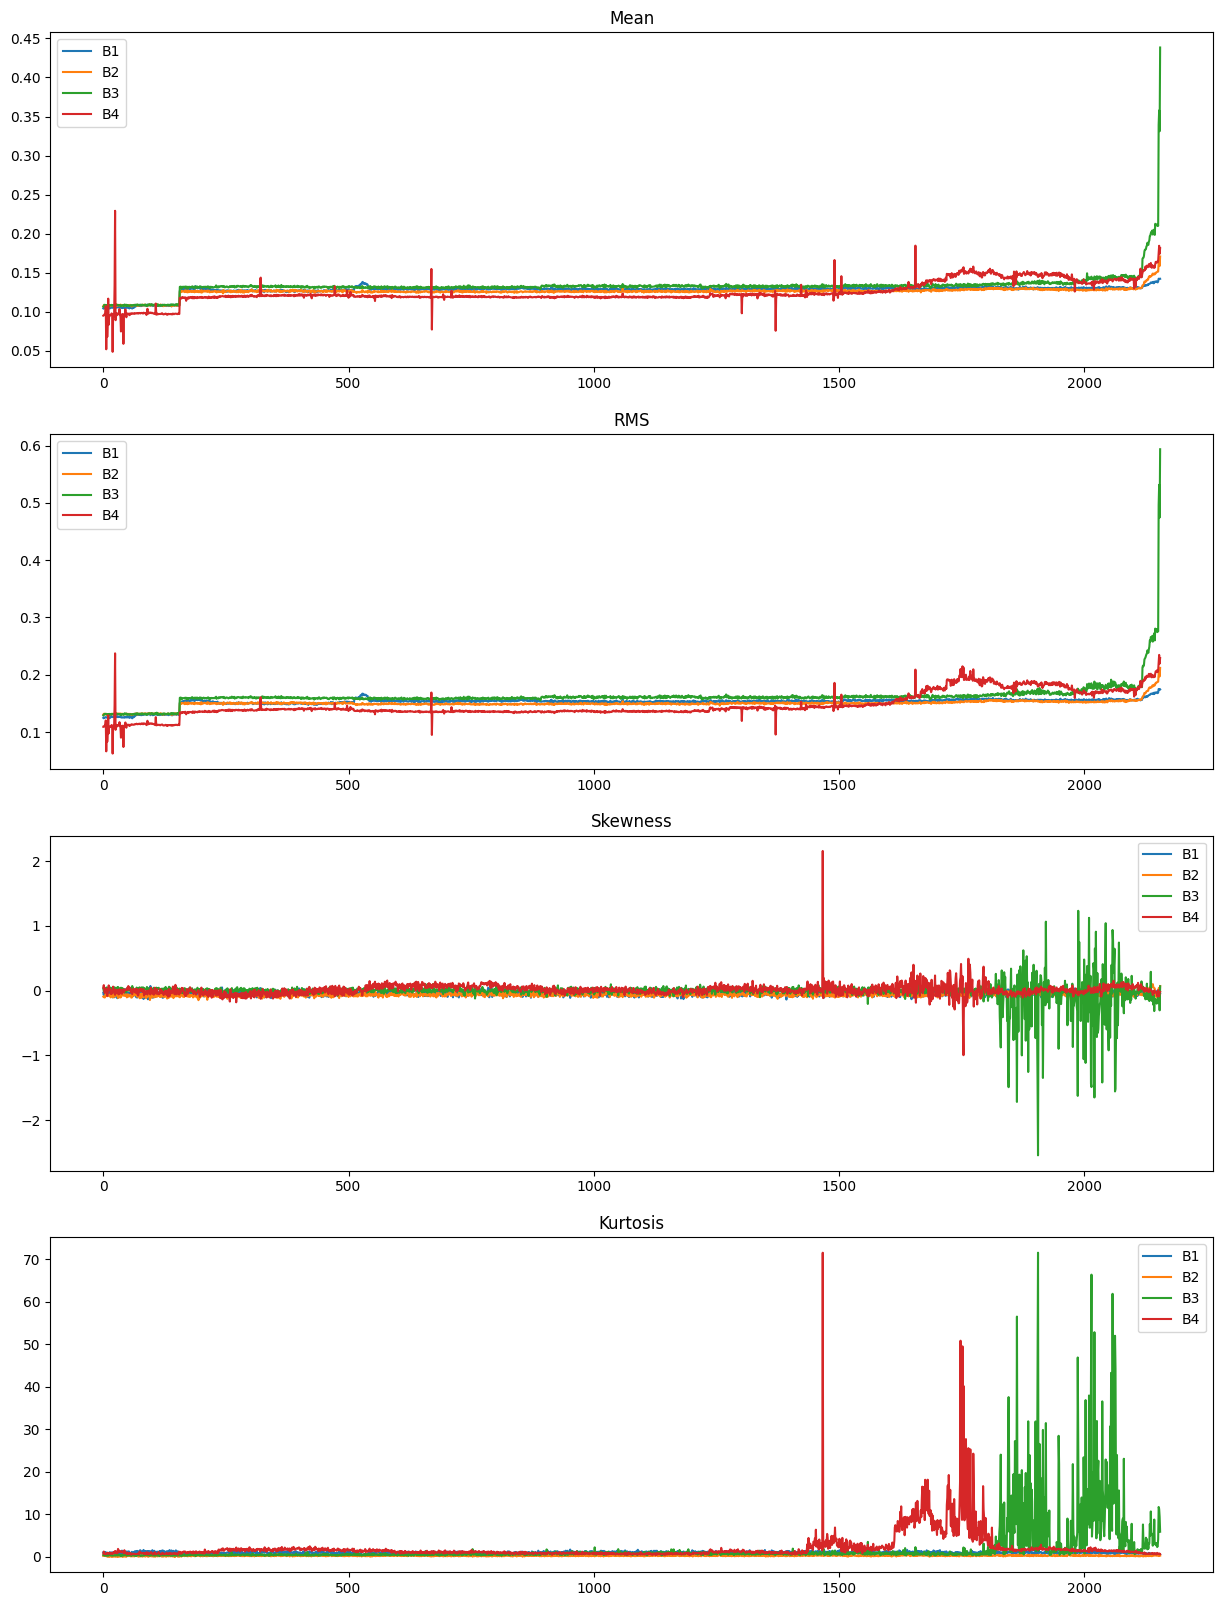

In [ ]:
plot_features2(set1)

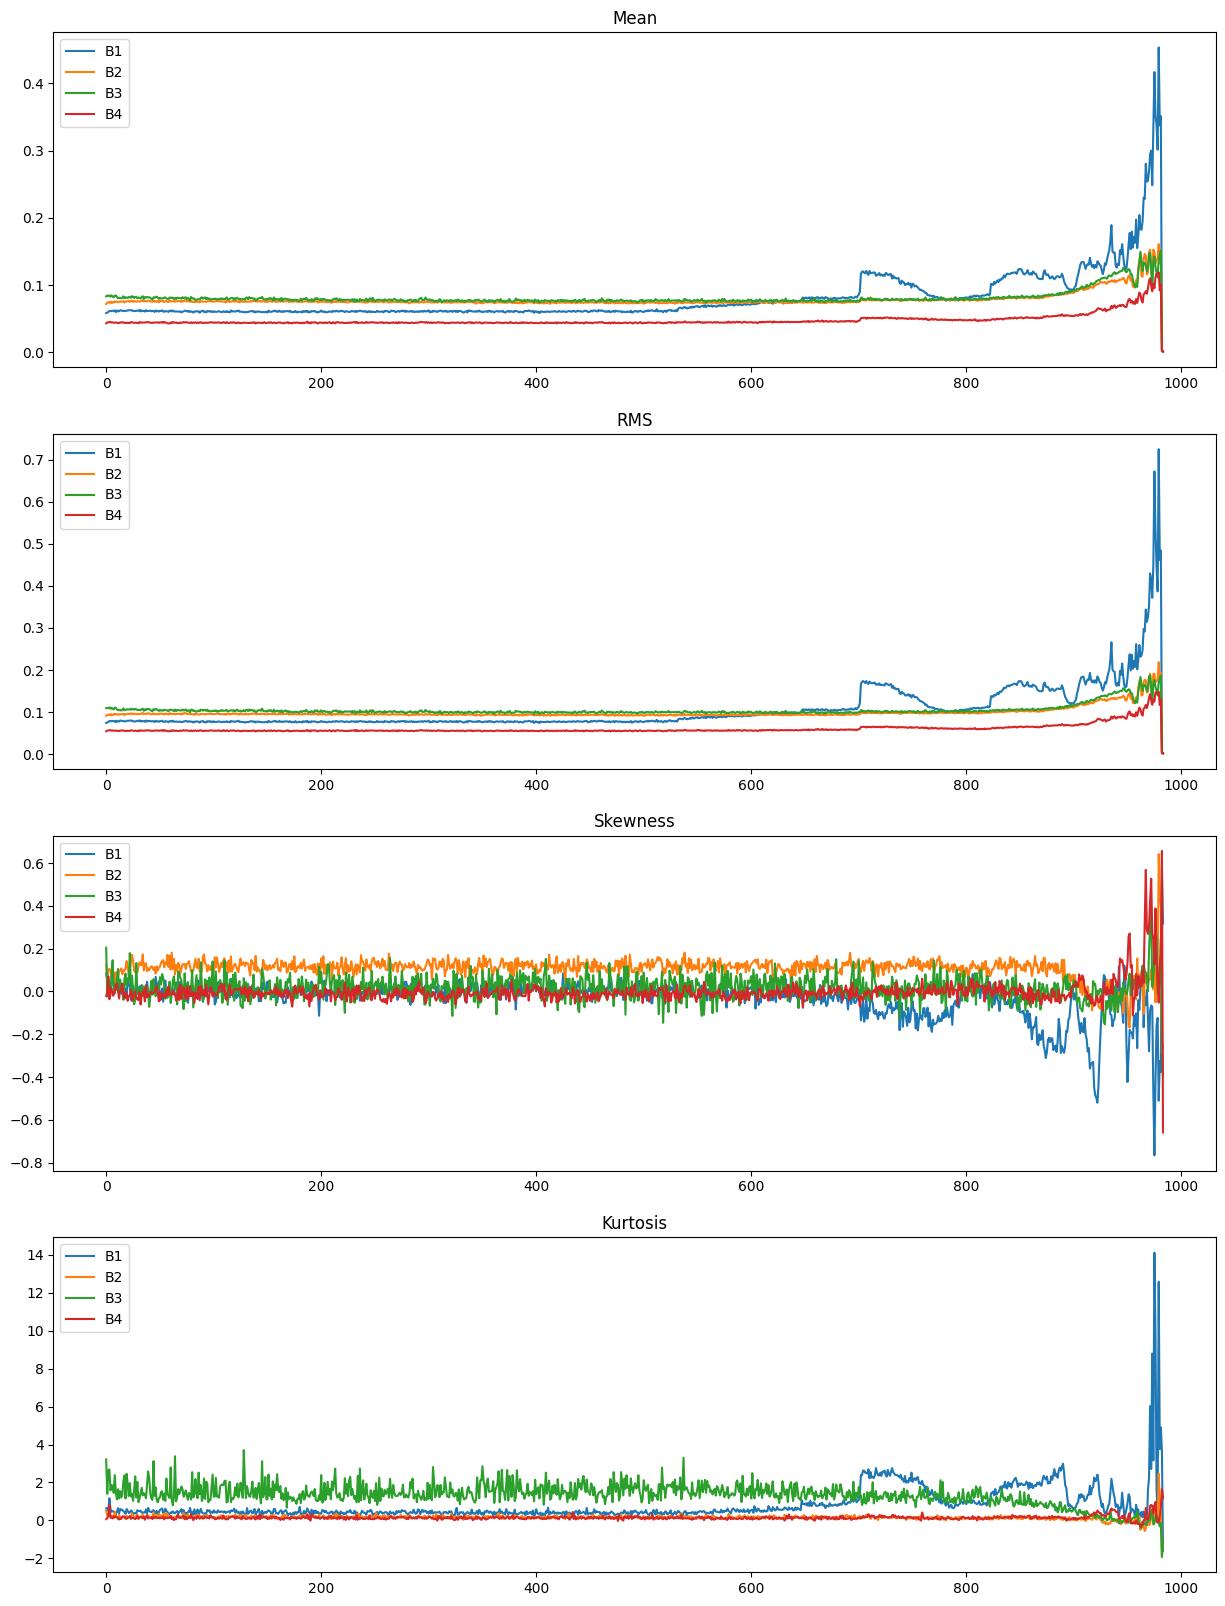

In [ ]:
plot_features(set2)

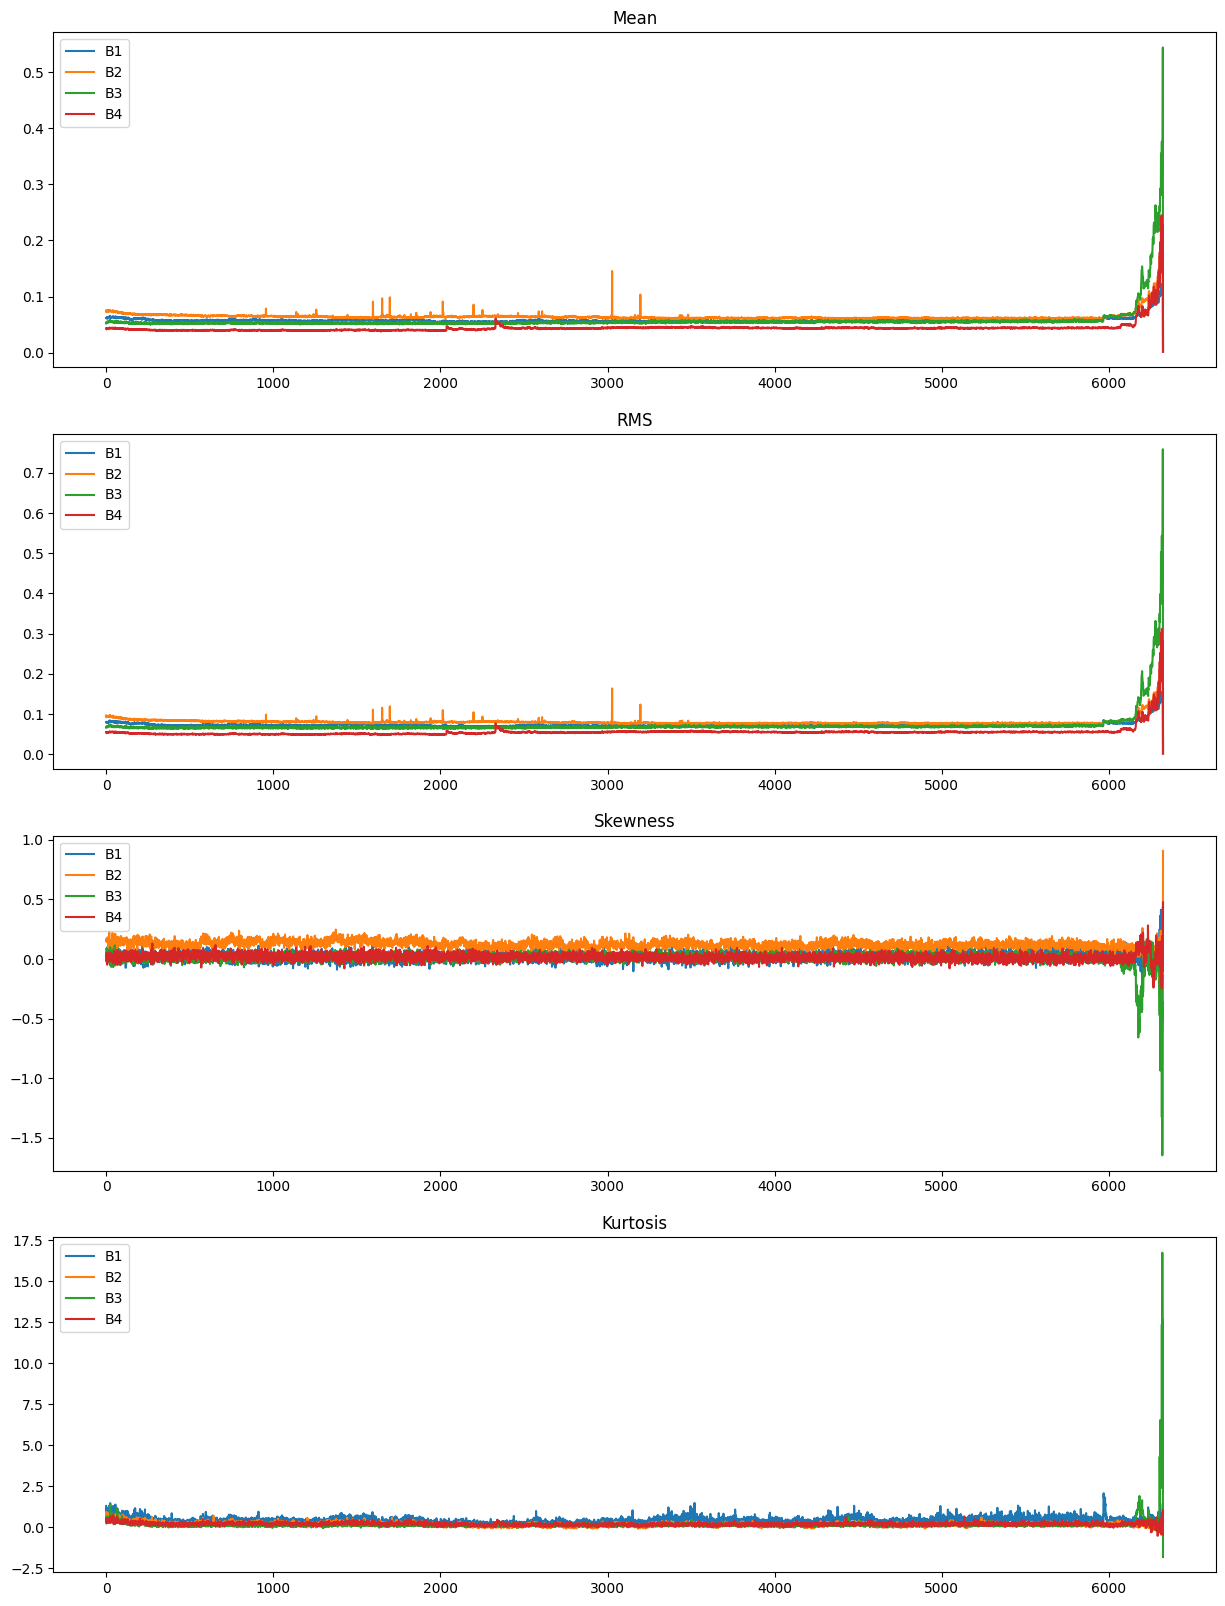

In [ ]:
plot_features(set3)

In [ ]:
set1.shape,set2.shape,set3.shape

((2156, 65), (984, 33), (6324, 33))

In [ ]:
set2_m = set2[["time","B1_mean"]]
set2_m.head()

,time,B1_mean
0,2004-02-12 10:32:39,0.058333
1,2004-02-12 10:42:39,0.058995
2,2004-02-12 10:52:39,0.060236
3,2004-02-12 11:02:39,0.061455
4,2004-02-12 11:12:39,0.061361


In [ ]:
set2_m.index = set2_m["time"]

In [ ]:
set2_m.drop("time",axis=1,inplace=True)

In [ ]:
set2_m.head()

,B1_mean
time,
2004-02-12 10:32:39,0.058333
2004-02-12 10:42:39,0.058995
2004-02-12 10:52:39,0.060236
2004-02-12 11:02:39,0.061455
2004-02-12 11:12:39,0.061361


In [ ]:
set2_m = set2_m.values

In [ ]:
set2_m = set2_m.astype('float32')

In [ ]:
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train , test , position

In [ ]:
train , test , position = split_data(set2_m , 0.2)

In [ ]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train);

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [ ]:
def create_features(data,lookback):
  X,Y =[] ,[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [ ]:
lookback = 5
#Train Veri Seti
X_train , y_train = create_features(train , lookback)
print(X_train.shape,y_train.shape)

(782, 5) (782,)


In [ ]:
#Test Veri Seti
X_test , y_test = create_features(test , lookback)
print(X_test.shape,y_test.shape)

(192, 5) (192,)


In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(782, 1, 5) (782, 1) (192, 1, 5) (192, 1)


In [ ]:
X_train.shape

(782, 1, 5)

In [ ]:
model = Sequential()

model.add(LSTM(units=50,
               activation='relu',
               input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.05))
model.add(Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                             save_best_only=True,save_weights_only=False,verbose=1)]

In [ ]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
776/782 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.00797, saving model to mymodel.h5
782/782 [==============================] - 6s 6ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 2/50
774/782 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 2: val_loss did not improve from 0.00797
782/782 [==============================] - 3s 4ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 3/50
772/782 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 3: val_loss did not improve from 0.00797
782/782 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 4/50
776/782 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 4: val_loss did not improve from 0.00797
782/782 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 5/50
780/782 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 5: val_loss did not improve from 0.00

Text(0.5, 1.0, 'Training and Validation Loss')

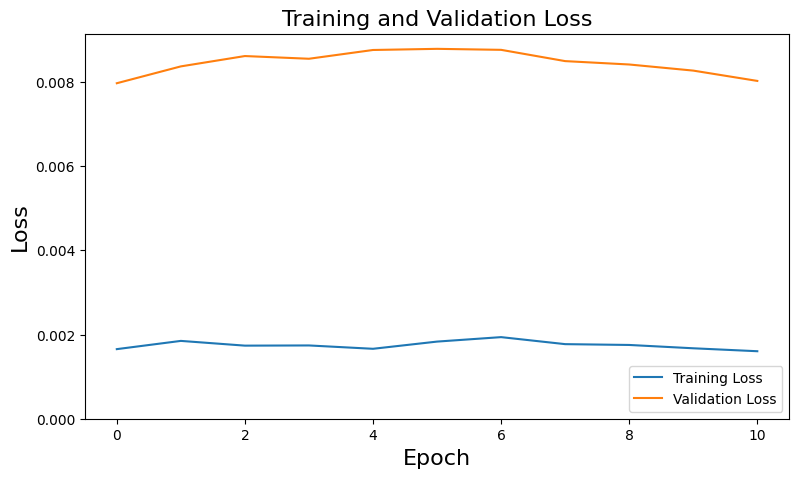

In [ ]:

#------------------------
#Loss Grafik
#------------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)

In [ ]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest loss: %.1f%%"%(100.0*loss))

192/192 [==============================] - 0s 2ms/step - loss: 0.0080

Test loss: 0.8%


In [ ]:
train_predict = model.predict(X_train)

25/25 [==============================] - 0s 2ms/step


In [ ]:
test_predict = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
y_train.shape

(782, 1)

In [ ]:
train_prediction_df=set2[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B2_mean,...,B3_p2p,B4_mean,B4_std,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p,Predicted
5,2004-02-12 11:22:39,0.061665,0.078296,0.026859,0.456893,4.876222,0.078311,0.439,0.805,0.073279,...,1.643,0.044172,0.055497,0.012718,0.149591,4.537805,0.055567,0.247,0.489,0.067648
6,2004-02-12 11:32:39,0.061944,0.078619,0.058509,0.479035,4.879129,0.078633,0.408,0.796,0.074593,...,1.614,0.044659,0.056206,-0.019688,0.108112,4.550264,0.056280,0.239,0.456,0.067892
7,2004-02-12 11:42:39,0.061231,0.077748,0.082494,0.472485,4.868507,0.077773,0.415,0.749,0.074172,...,1.547,0.043840,0.055458,-0.017240,0.210142,4.536200,0.055505,0.229,0.456,0.068091
8,2004-02-12 11:52:39,0.062280,0.079007,-0.008154,0.405109,4.886069,0.079029,0.386,0.747,0.075808,...,1.736,0.044272,0.055798,0.008433,0.160372,4.542952,0.055855,0.330,0.557,0.067882
9,2004-02-12 12:02:39,0.059890,0.075688,0.046385,0.325913,4.843951,0.075715,0.378,0.722,0.075115,...,1.445,0.043974,0.055393,0.029720,0.206311,4.534484,0.055461,0.291,0.545,0.068111


In [ ]:
test_prediction_df=set2[lookback+position:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B2_mean,...,B3_p2p,B4_mean,B4_std,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p,Predicted
792,2004-02-17 22:32:39,0.079492,0.102749,-0.065915,0.764884,5.075770,0.102756,0.608,1.128,0.077422,...,1.208,0.047779,0.060103,-0.063082,0.050548,4.616613,0.060165,0.281,0.523,0.108093
793,2004-02-17 22:42:39,0.079561,0.103235,-0.076276,0.831201,5.143271,0.103247,0.530,0.969,0.077910,...,1.447,0.048014,0.060068,0.035872,0.010901,4.615596,0.060132,0.271,0.503,0.108462
794,2004-02-17 22:52:39,0.080711,0.104729,-0.047362,0.867679,5.142650,0.104741,0.559,1.025,0.077490,...,1.355,0.048853,0.061160,0.006604,0.069818,4.634337,0.061248,0.273,0.546,0.108848
795,2004-02-17 23:02:39,0.080806,0.105442,-0.004118,1.040981,5.096304,0.105457,0.535,1.048,0.078311,...,1.321,0.048306,0.060662,0.011426,0.100332,4.626897,0.060727,0.283,0.539,0.109396
796,2004-02-17 23:12:39,0.080193,0.104165,-0.033155,0.978381,5.121989,0.104178,0.557,1.084,0.077519,...,1.340,0.047725,0.060227,0.034209,0.170717,4.617628,0.060275,0.269,0.533,0.109677


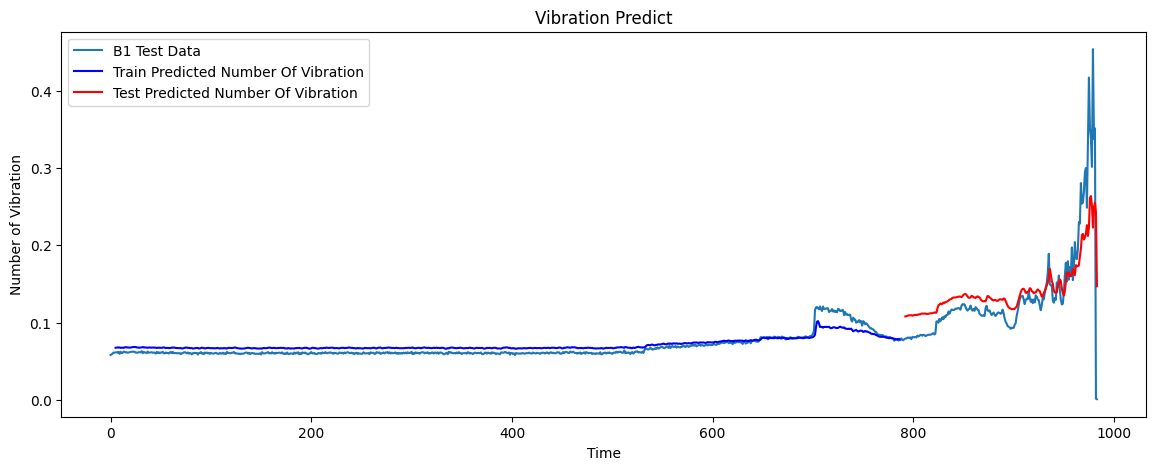

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(set2_m,label="B1 Test Data ")
plt.plot(train_prediction_df["Predicted"],color='blue',label='Train Predicted Number Of Vibration')
plt.plot(test_prediction_df["Predicted"],color='red',label='Test Predicted Number Of Vibration')
plt.title('Vibration Predict')
plt.xlabel('Time')
plt.ylabel('Number of Vibration')
plt.legend()
plt.show()

In [ ]:
# Stop the Spark session
spark.stop()